In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

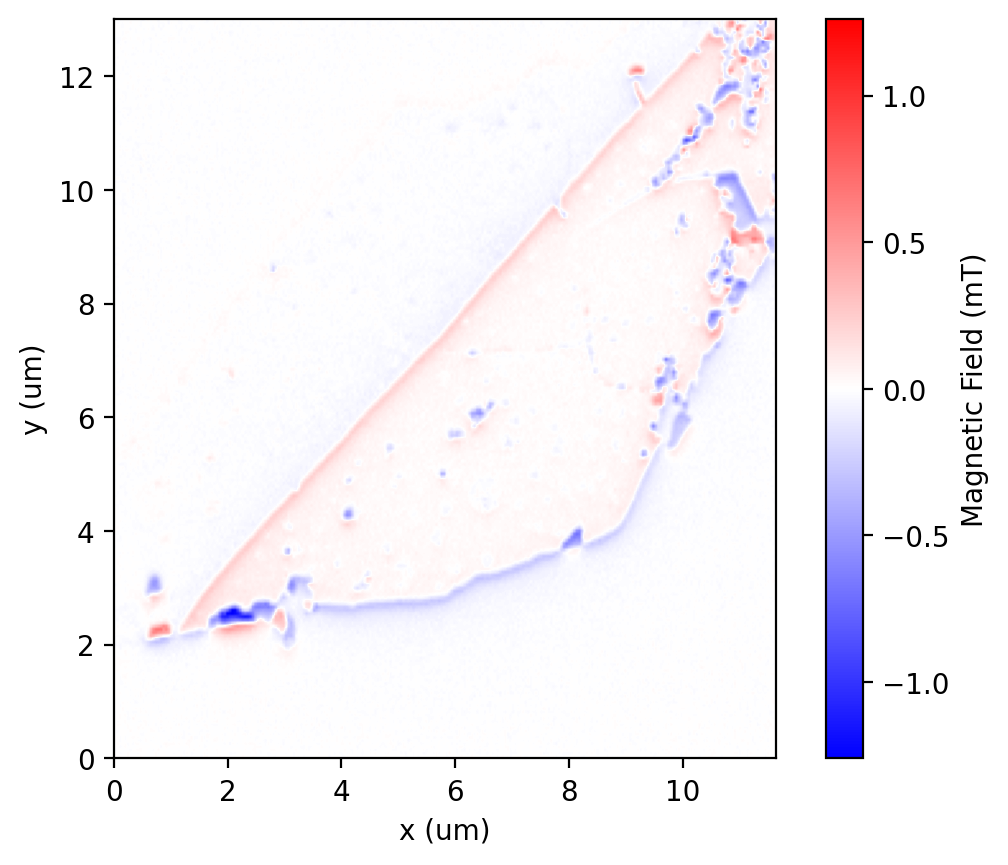

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.05, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.plot_target()


In [5]:
# Add filter 
dataset.add_hanning_filter(0.05)
dataset.add_hanning_filter(0.05)

[11, 244, 0, 256]


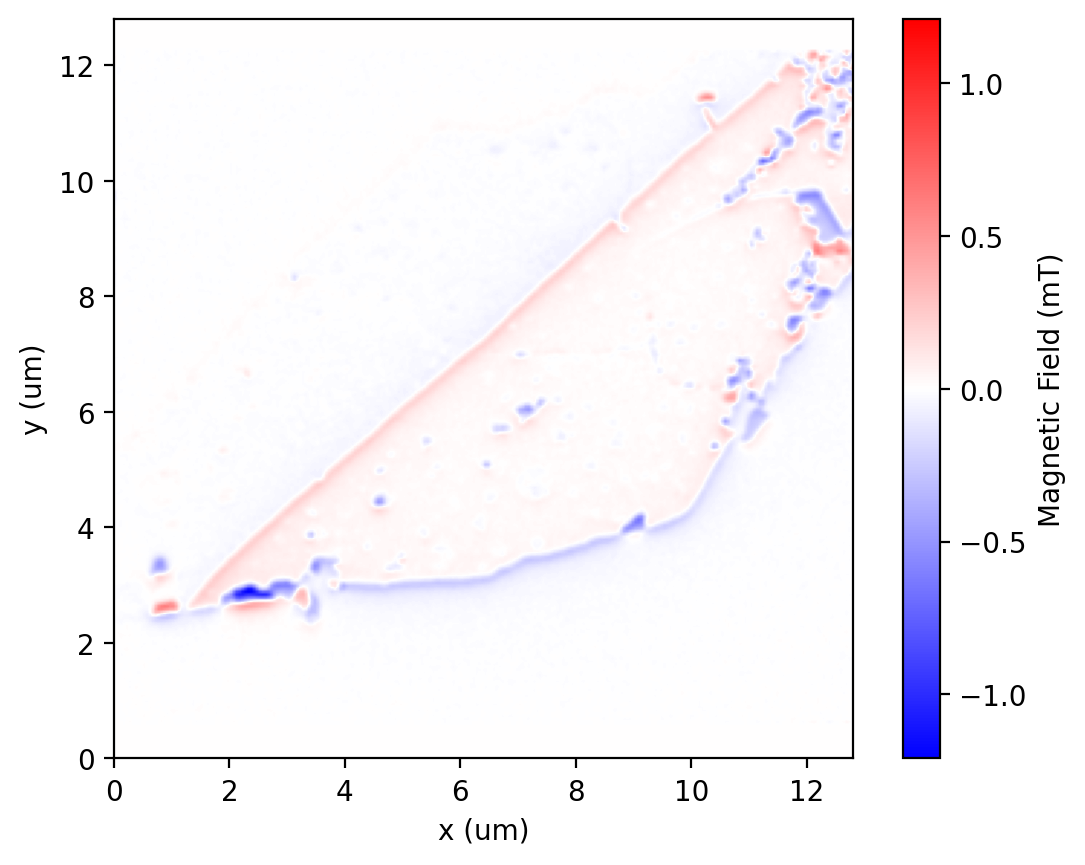

In [6]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

# Transfor Bsensor into Bxyz

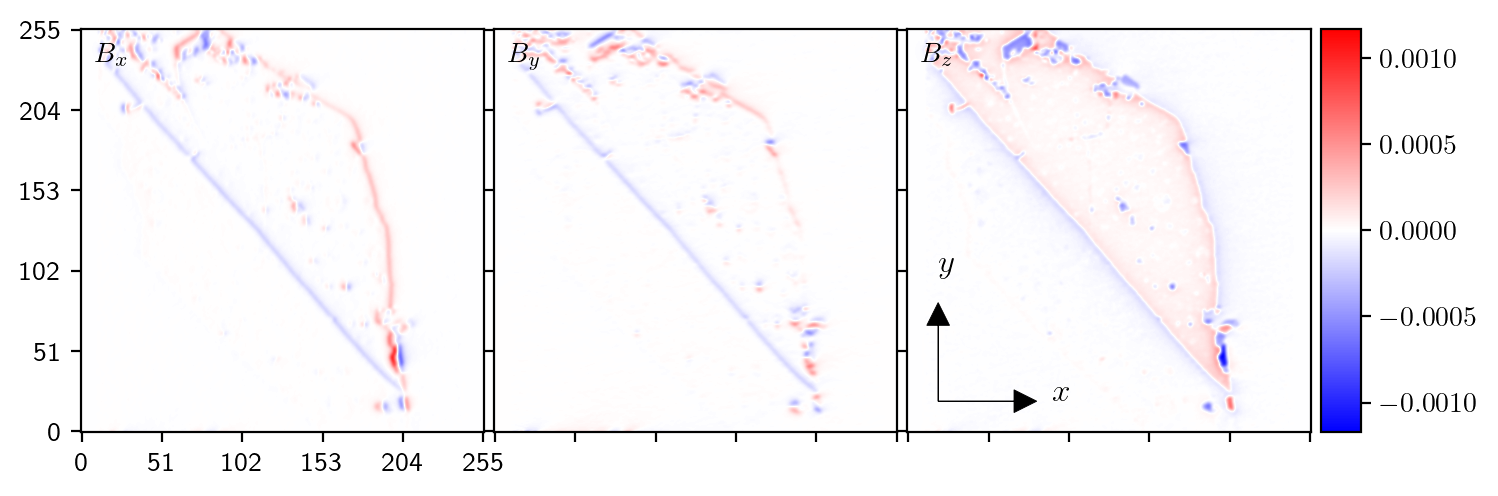

In [7]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Now we will try to reconstruct the magnetisation using a neural network.

In [64]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

dataset4 = copy.deepcopy(dataset)
dataset4.target = dataset4.target*1e6

Model = UniformMagnetisation(dataset4, "MSE", m_theta = 0, m_phi = 0)
FittingMethod = FCNN(Model, dataset4)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1
65536


In [65]:
FittingMethod.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  3.94e+03
epoch    11 | loss on last mini-batch:  3.94e+03
epoch    21 | loss on last mini-batch:  3.93e+03
epoch    31 | loss on last mini-batch:  3.65e+03
epoch    41 | loss on last mini-batch:  2.48e+03
epoch    51 | loss on last mini-batch:  1.31e+03
epoch    61 | loss on last mini-batch:  7.99e+02
epoch    71 | loss on last mini-batch:  4.41e+02
epoch    81 | loss on last mini-batch:  2.63e+02
epoch    91 | loss on last mini-batch:  1.65e+02


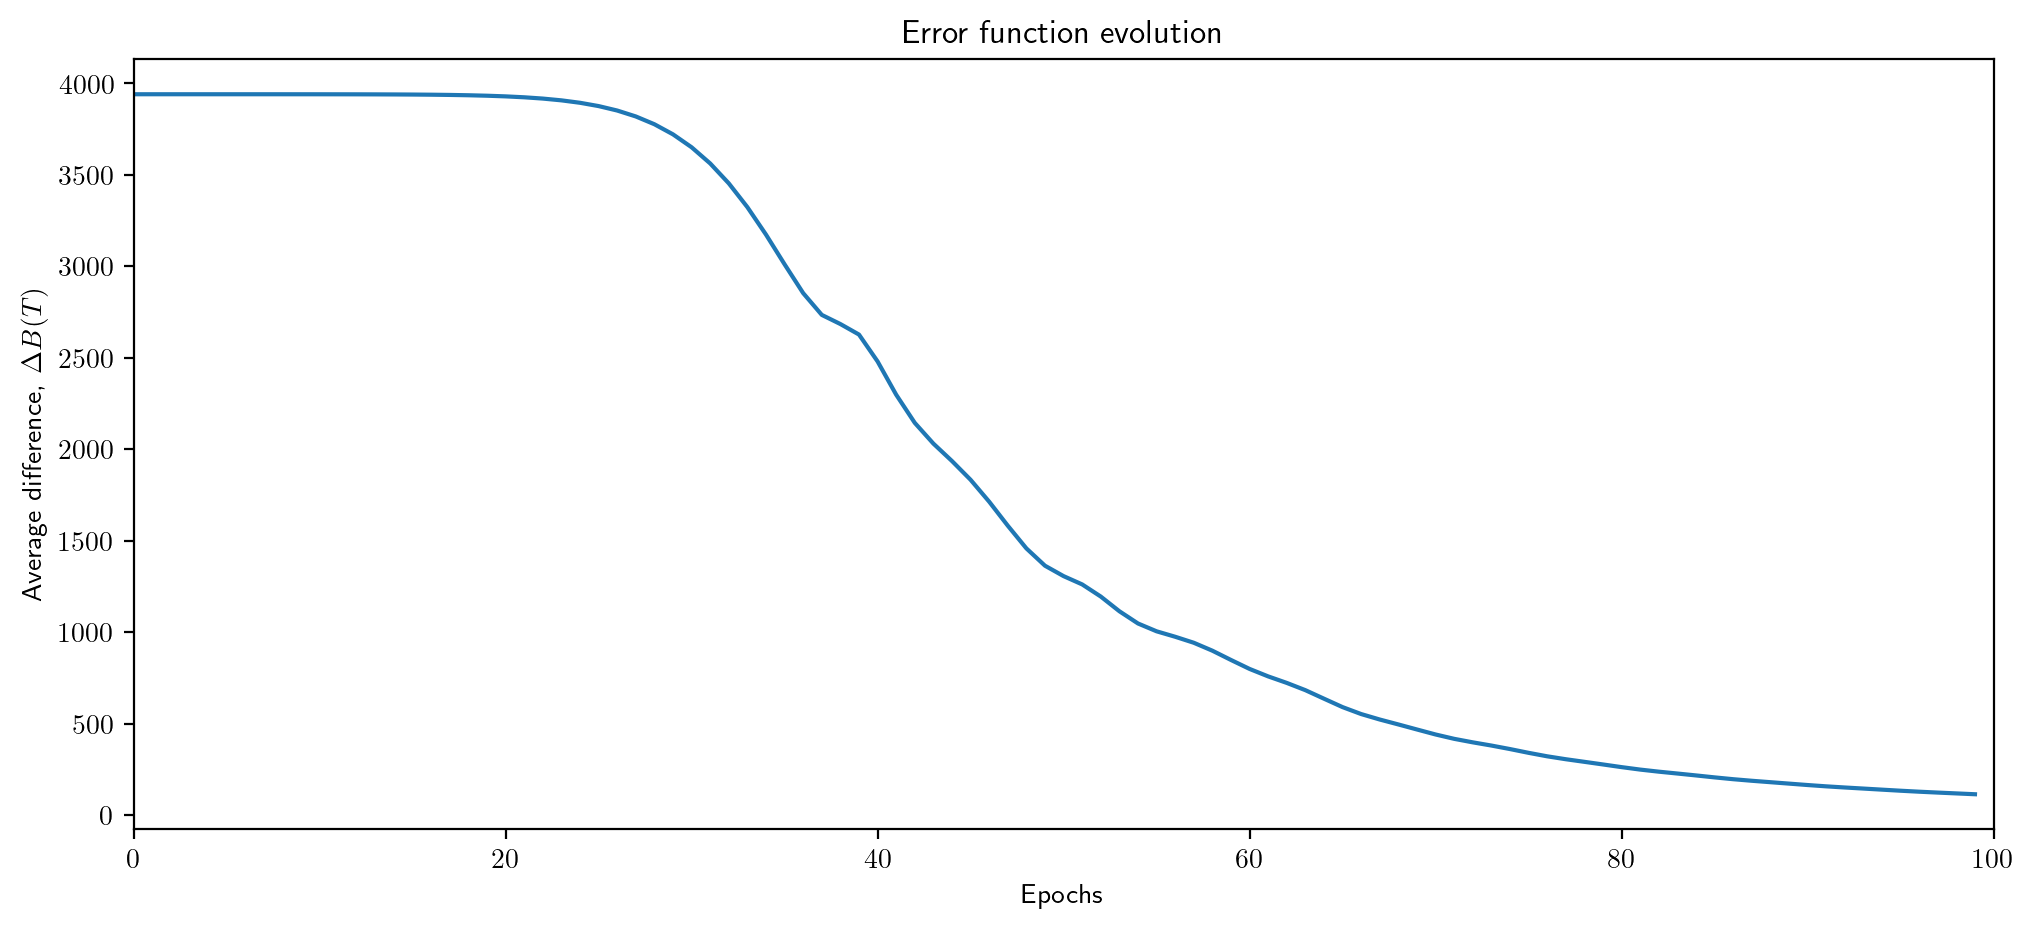

In [66]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


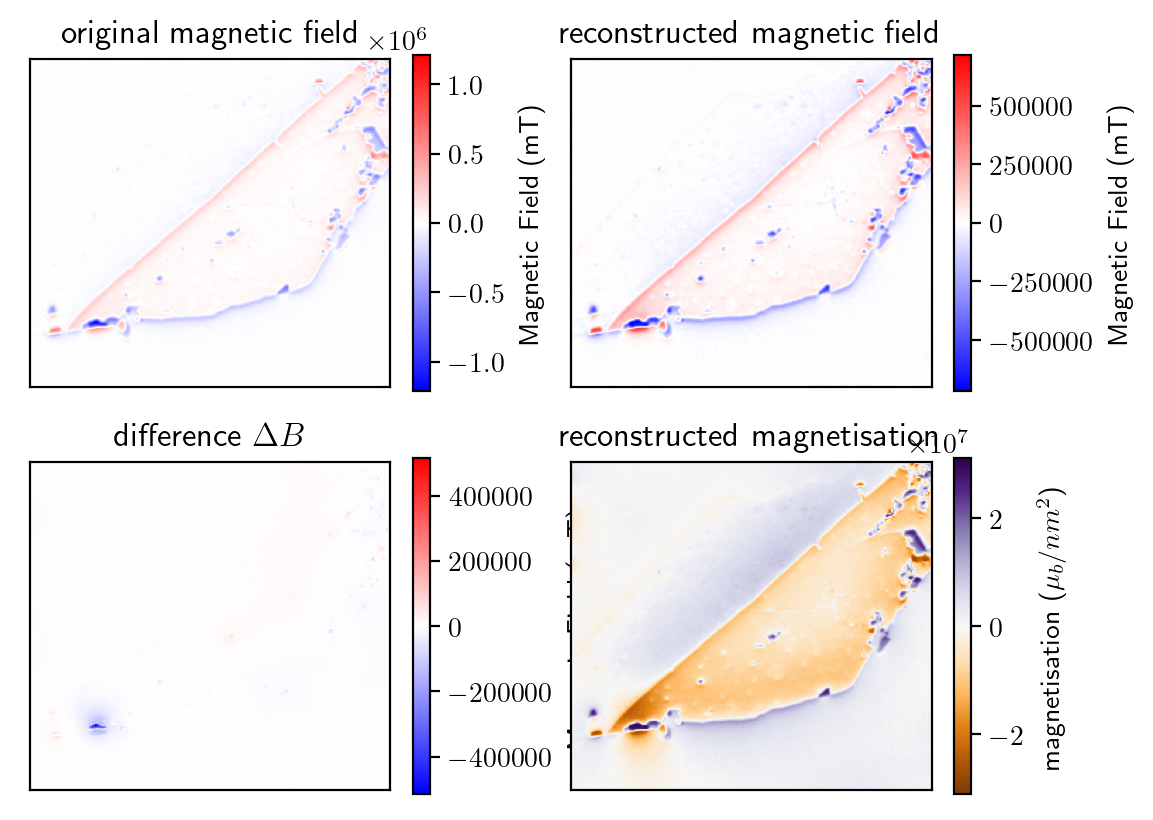

In [67]:
FittingMethod.plot_results()

# Now try recon in Fourier space

In [ ]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMxyFspace import UniformMxyFspace as Mrecon

dataset5 = copy.deepcopy(dataset)
dataset5.target = dataset5.target*1e6

Model = Mrecon(dataset5, "MSE", m_theta = 0, m_phi = 0)
FittingMethod = FCNN(Model, dataset5)
FittingMethod.prepare_fit()